# 네이버 영화리뷰 감성분석

데이터셋: 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)

## 데이터 준비와 확인

In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

`data_loader` 안에서는 다음을 수행한다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴





In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = set(['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'])

In [3]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

### 데이터 실제 예시 확인

In [5]:
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [6]:
print(X_train[0])           # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
dict(list(index_to_word.items())[:10]) 

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게'}

In [9]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])      # '<BOS>' 출력
print(word_to_index['영화'])  # 5 출력
print(index_to_word[5])      # '영화' 출력

<BOS>
5
영화


### 텍스트를 숫자로 표현하는 방법

#### `get_encoded_sentence` 함수
- 한 문장을 받아서 해당 문장을 단어 인덱스 리스트로 변환해주는 기능을 수행  
- 여기서 사용하는 `word_to_index`는 단어를 키로, 그 단어의 인덱스를 값으로 가지는 사전(dictionary)이다. 
    - 이 사전은 모델이 이해할 수 있는 형태로 텍스트 데이터를 변환하는 데 사용된다.
- 단, 모든 문장은 <BOS>로 시작하는 것으로 한다.

**함수 동작 방식**
- 입력 문장의 시작을 표시
    - 모든 변환된 문장은 <BOS> (Begin Of Sentence) 토큰으로 시작한다. 
    - 이는 문장의 시작을 나타내며, 이 토큰 또한 `word_to_index` 사전을 사용하여 해당 인덱스로 변환된다.
- 문장 토큰화 및 인덱스 변환
    - 입력된 문장을 공백을 기준으로 단어 단위로 분리한다. `sentence.split()`
    - 이후 각 단어에 대해 `word_to_index` 사전을 조회하여 해당 단어의 인덱스를 가져온다. 
    - 만약 단어가 사전에 존재하지 않는 경우, <UNK> (Unknown) 토큰의 인덱스를 사용한다. (모르는 단어를 처리하는 방법)
- 결과: 이 과정을 거친 후, 모든 단어가 인덱스로 변환된 리스트를 반환한다. 

In [10]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

#### `get_encoded_sentences` 함수
- 여러 개의 문장으로 구성된 리스트를 입력 받아, 각 문장을 단어 인덱스 리스트로 변환하는 작업을 수행
- 이 함수는 내부적으로 `get_encoded_sentence` 함수를 사용하여 개별 문장을 처리한다.

**함수의 작동 방식**
- 입력
    - `sentences`는 변환하고자 하는 문장들의 리스트이다.
    - `word_to_index`는 단어와 그에 해당하는 인덱스가 매핑된 사전이다.
- 문장별 인코딩
    - 입력된 sentences 리스트에 포함된 각 문장에 대해, `get_encoded_sentence` 함수를 호출하여 해당 문장을 단어 인덱스 리스트로 변환한다. 
    - 이 과정에서 모든 문장은 <BOS> 토큰으로 시작하며, 사전에 없는 단어는 <UNK>로 처리된다.
- 결과: 변환된 단어 인덱스 리스트들의 리스트를 반환한다.

In [11]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#### `get_decoded_sentence` 함수
- 숫자 인덱스로 인코딩된 문장을 다시 원래의 텍스트 문장으로 디코딩하는 역할을 수행
- 이 과정에서 index_to_word라는 사전을 사용하는데, 이 사전은 숫자 인덱스를 키로 하고, 해당 인덱스에 해당하는 단어를 값으로 가진다.

**함수의 작동 방식**
- 입력
    - `encoded_sentence`는 단어의 인덱스로 이루어진 리스트이다.
    - 이 리스트는 앞서 언급한 `get_encoded_sentence` 함수를 통해 생성될 수 있다. 
        - `index_to_word`는 인덱스를 단어로 매핑하는 사전이다.
- <BOS> 토큰 제외
    - 디코딩 과정에서는 문장의 시작을 나타내는 <BOS> 토큰이 실제 텍스트로 변환되지 않도록 리스트의 첫 번째 요소를 제외한다. `(encoded_sentence[1:])`
        - <BOS> 토큰이 실제 텍스트의 일부가 아니기 때문이다.

- 디코딩
    - 인코딩된 문장을 순회하며, 각 인덱스에 해당하는 단어를 `index_to_word` 사전을 통해 찾는다. 
    - 만약 특정 인덱스가 사전에 없는 경우 <UNK>(알 수 없는 단어)로 처리한다. 
        - 이 과정을 통해 모든 인덱스가 원래의 단어로 변환된다.
- 결과: 변환된 단어들을 공백으로 구분하여 하나의 문자열로 결합한다.
    - 인코딩된 숫자 벡터가 원래의 텍스트 문장으로 복원한다.

In [12]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

#### `get_decoded_sentences` 함수
- 여러 개의 숫자 벡터로 인코딩된 문장들을 받아서 이를 한꺼번에 원래의 텍스트 문장들로 디코딩하는 기능을 수행 
- 이 함수는 내부적으로 get_decoded_sentence 함수를 사용하여 각각의 인코딩된 문장을 디코딩한다.

**함수의 작동 과정**
- 입력
    - `encoded_sentences`는 인코딩된 문장들의 리스트이다. 
        - 각 문장은 단어의 인덱스로 이루어진 리스트 형태로 되어 있다. 
    - `index_to_word`는 인덱스를 키로, 해당 인덱스의 단어를 값으로 가지는 사전이다.
- 문장별 디코딩
    - 입력된 `encoded_sentences` 리스트에 포함된 각 인코딩된 문장에 대하여, `get_decoded_sentence` 함수를 호출하여 이를 디코딩한다. 
    - 디코딩 과정에서는 문장의 시작을 나타내는 <BOS> 토큰을 제외하고, 각 인덱스에 해당하는 단어로 변환한다. 
        - 사전에 없는 인덱스는 <UNK>로 처리된다.
- 결과: 디코딩된 각 문장을 문자열 형태로 변환한 뒤, 이를 모아 새로운 리스트로 만들어 반환한다. 
    - 결과적으로, 이 함수는 인코딩된 문장들의 리스트를 입력으로 받아, 각각을 디코딩한 텍스트 문장들의 리스트를 반환한다.

In [13]:
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

텍스트가 숫자로 변환되어 인공지능 모델의 입력으로 사용될 수 있게 되었지만, 이것으로 충분하지는 않다.   
'i feel hungry'가 1, 3, 4, 5 로 변환되었지만 이 벡터는 텍스트에 담긴 언어의 의미와 대응되는 벡터가 아니라 임의로 부여된 단어의 순서에 불과하다.   
우리가 하려는 것은 단어와 그 단어의 의미를 나타내는 벡터를 짝짓는 것이다.   
그래서 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해서 최적화하게 된다.  
Tensorflow, Pytorch 등의 딥러닝 프레임워크들은 이러한 의미 벡터 파라미터를 구현한 Embedding 레이어를 제공한다.


> 임베딩(Embedding)이란?  
자연어 처리(Natural Language Processing)분야에서 임베딩(Embedding)은 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자형태인 vector로 바꾼 결과 혹은 그 일련의 과정 전체를 의미한다. 가장 간단한 형태의 임베딩은 단어의 빈도를 그대로 벡터로 사용하는 것이다.  
임베딩을 통해 할수있는 것은 단어나 문장 사이의 코사인 유사도가 가장 높은 단어를 구하는 등의 계산, 단어들 사이의 의미/문법적 정보 도출 벡터 간 연산으로 단어 사이 문법적 관계 도출, 전이 학습(transfer learning)
임베딩은 다른 딥러닝 모델의 입력값으로 자주 쓰이고, 품질 좋은 임베딩을 쓸수록 모델의 성능이 좋아집니다.

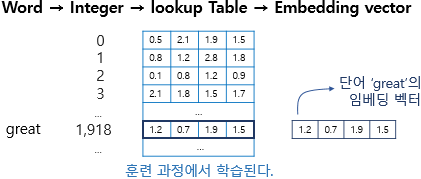

### 데이터셋 내 문장 길이 분포

#### 데이터셋 내 문장 길이 분석

In [14]:
train_lengths = [len(s) for s in X_train]
test_lengths = [len(s) for s in X_test]

In [15]:
print("max length")
print(f"Train sentence max length: {np.max(train_lengths)}")
print(f"Test sentence max length: {np.max(test_lengths)}\n")

print("average length")
print(f"Train sentence average length: {np.mean(train_lengths)}")
print(f"Test sentence average length: {np.mean(test_lengths)}\n")

print("standard deviation")
print(f"Train sentence length standard deviation: {np.std(train_lengths)}")
print(f"Test sentence length standard deviation: {np.std(test_lengths)}")

max length
Train sentence max length: 116
Test sentence max length: 105

average length
Train sentence average length: 15.98170773419436
Test sentence average length: 15.932807128181134

standard deviation
Train sentence length standard deviation: 12.82473766384545
Test sentence length standard deviation: 12.899346084223861


#### 문장 길이 분포 시각화

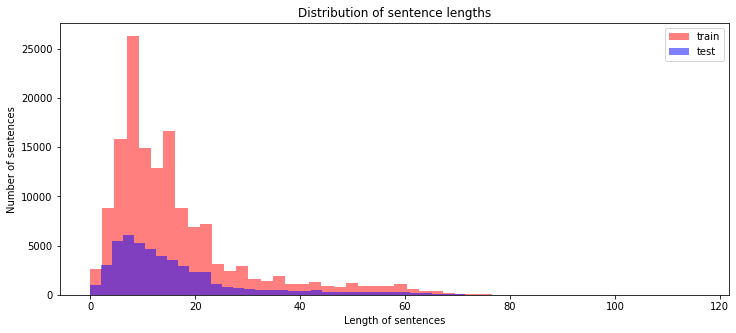

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(train_lengths, bins=50, alpha=0.5, color='r', label='train')
plt.hist(test_lengths, bins=50, alpha=0.5, color='b', label='test')
plt.title('Distribution of sentence lengths')
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')
plt.legend()
plt.show()

### 적절한 최대 문장 길이 지정

In [17]:
max_length = int(np.mean(train_lengths) + 2 * np.std(train_lengths))
print(f"Chosen max sentence length: {max_length}")

Chosen max sentence length: 41


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [18]:
import tensorflow as tf

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train, 
                                                               value=word_to_index["<PAD>"],
                                                               maxlen=max_length, 
                                                               padding='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                              value=word_to_index["<PAD>"],
                                                              maxlen=max_length, 
                                                              padding='post')

# 패딩된 데이터셋의 형태를 확인
print(f"Shape of X_train_padded: {X_train_padded.shape}")
print(f"Shape of X_test_padded: {X_test_padded.shape}")

Shape of X_train_padded: (146182, 41)
Shape of X_test_padded: (49157, 41)


## 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

In [21]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test_padded.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (116945, 41)
y train shape: (116945,)
X test shape: (49157, 41)
y test shape: (49157,)


In [22]:
vocab_size = len(word_to_index) + 1  # 사전에 없는 단어를 위한 1 추가
print(vocab_size)

10002


In [23]:
word_vector_dim = 100

In [24]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for word, i in word_to_index.items():
    if i < vocab_size:
        embedding_vector = np.random.rand(word_vector_dim)  # 예시로 랜덤 벡터 사용
        embedding_matrix[i] = embedding_vector              # 임베딩 행렬에 단어 인덱스에 해당하는 벡터 저장

### Simple RNN Model

In [25]:
model_rnn = Sequential([
    Embedding(vocab_size, 
              word_vector_dim, 
              input_length=max_length,
              weights=[embedding_matrix],
              trainable=True),
    SimpleRNN(512, return_sequences=True),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

#### 모델 컴파일

In [26]:
model_rnn.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

#### 모델 요약 출력

In [27]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 100)           1000200   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 41, 512)           313856    
_________________________________________________________________
dropout (Dropout)            (None, 41, 512)           0         
_________________________________________________________________
dense (Dense)                (None, 41, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 64)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 41, 1)             65        
Total params: 1,346,953
Trainable params: 1,346,953
Non-trainable params: 0
______________________________________________

### 1D CNN Model

In [28]:
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=word_vector_dim, 
              embeddings_initializer=Constant(embedding_matrix),  # 사전 훈련된 임베딩을 초기값으로 사용
              weights=[embedding_matrix],
              input_length=max_length, 
              trainable=True),  # 임베딩 레이어를 학습 가능하게 설정
    
    Conv1D(512, 7, activation='relu', padding='same'),
    Conv1D(1024, 7, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

#### 모델 컴파일

In [29]:
model_cnn.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

#### 모델 요약 출력

In [30]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 100)           1000200   
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 512)           358912    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 41, 1024)          3671040   
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

### LSTM Model

In [31]:
model_lstm = Sequential([
    Embedding(vocab_size, 
              word_vector_dim, 
              input_length=max_length,
              weights=[embedding_matrix],
              trainable=True),
    LSTM(512),
    Dense(1, activation='sigmoid'),
])

#### 모델 컴파일

In [32]:
model_lstm.compile(optimizer='adam', 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

#### 모델 요약 출력

In [33]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 100)           1000200   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1255424   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 2,256,137
Trainable params: 2,256,137
Non-trainable params: 0
_________________________________________________________________


## 모델 훈련 개시

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상: 'val_loss'
                               patience=10,         # 10번의 에폭 동안 개선되지 않으면 조기 종료합
                               verbose=1)           # 조기 종료 시 메시지 출력

In [35]:
epochs = 100
batch_size = 128

### Simple RNN Model

In [36]:
history_rnn = model_rnn.fit(X_train, y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_val, y_val), 
                            callbacks=[early_stopping],  
                            verbose=1)

Epoch 1/100
914/914 [==============================] - 52s 43ms/step - loss: 0.6941 - accuracy: 0.5005 - val_loss: 0.6927 - val_accuracy: 0.5027
Epoch 2/100
914/914 [==============================] - 39s 43ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 3/100
914/914 [==============================] - 39s 42ms/step - loss: 0.6929 - accuracy: 0.5025 - val_loss: 0.6920 - val_accuracy: 0.5029
Epoch 4/100
914/914 [==============================] - 39s 42ms/step - loss: 0.6920 - accuracy: 0.5070 - val_loss: 0.6895 - val_accuracy: 0.5142
Epoch 5/100
914/914 [==============================] - 39s 42ms/step - loss: 0.6809 - accuracy: 0.5431 - val_loss: 0.6912 - val_accuracy: 0.5273
Epoch 6/100
914/914 [==============================] - 39s 42ms/step - loss: 0.6899 - accuracy: 0.5178 - val_loss: 0.6877 - val_accuracy: 0.5565
Epoch 7/100
914/914 [==============================] - 39s 43ms/step - loss: 0.6804 - accuracy: 0.5382 - val_loss: 0.6278 - val_ac

### 1D CNN Model

In [37]:
history_cnn = model_cnn.fit(X_train, y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_val, y_val), 
                            callbacks=[early_stopping],  
                            verbose=1)

Epoch 1/100
914/914 [==============================] - 65s 35ms/step - loss: 0.6940 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 2/100
914/914 [==============================] - 30s 33ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 3/100
914/914 [==============================] - 30s 33ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 4/100
914/914 [==============================] - 30s 33ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 5/100
914/914 [==============================] - 30s 33ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 6/100
914/914 [==============================] - 30s 33ms/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 7/100
914/914 [==============================] - 30s 33ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_ac

### LSTM Model

In [38]:
history_lstm = model_lstm.fit(X_train, y_train, 
                             epochs=epochs, 
                             batch_size=batch_size, 
                             validation_data=(X_val, y_val), 
                             callbacks=[early_stopping],  
                             verbose=1)

Epoch 1/100
914/914 [==============================] - 23s 19ms/step - loss: 0.6939 - accuracy: 0.5090 - val_loss: 0.6910 - val_accuracy: 0.5027
Epoch 2/100
914/914 [==============================] - 17s 19ms/step - loss: 0.4193 - accuracy: 0.7957 - val_loss: 0.3394 - val_accuracy: 0.8529
Epoch 3/100
914/914 [==============================] - 17s 19ms/step - loss: 0.3092 - accuracy: 0.8688 - val_loss: 0.3216 - val_accuracy: 0.8618
Epoch 4/100
914/914 [==============================] - 17s 19ms/step - loss: 0.2772 - accuracy: 0.8840 - val_loss: 0.3192 - val_accuracy: 0.8615
Epoch 5/100
914/914 [==============================] - 17s 19ms/step - loss: 0.2554 - accuracy: 0.8954 - val_loss: 0.3244 - val_accuracy: 0.8623
Epoch 6/100
914/914 [==============================] - 17s 19ms/step - loss: 0.2360 - accuracy: 0.9040 - val_loss: 0.3290 - val_accuracy: 0.8559
Epoch 7/100
914/914 [==============================] - 17s 19ms/step - loss: 0.2161 - accuracy: 0.9139 - val_loss: 0.3637 - val_ac

## Loss, Accuracy 그래프 시각화

### Simple RNN Model

1. RNN 모델의 검증 정확도: 0.8004
2. RNN 모델의 검증 정확도: 0.8281
3. RNN 모델의 검증 정확도: 0.8197
4. RNN 모델의 검증 정확도: 0.8326
5. RNN 모델의 검증 정확도: 0.8144
6. RNN 모델의 검증 정확도: 0.5055
7. RNN 모델의 검증 정확도: 0.7994
8. RNN 모델의 검증 정확도: 0.7949

In [39]:
loss, accuracy = model_rnn.evaluate(X_val, y_val, verbose=1)
print(f"RNN 모델의 검증 정확도: {accuracy:.4f}")

914/914 [==============================] - 6s 7ms/step - loss: 0.4302 - accuracy: 0.8108
RNN 모델의 검증 정확도: 0.8108


#### 손실(Loss) 그래프 시각화

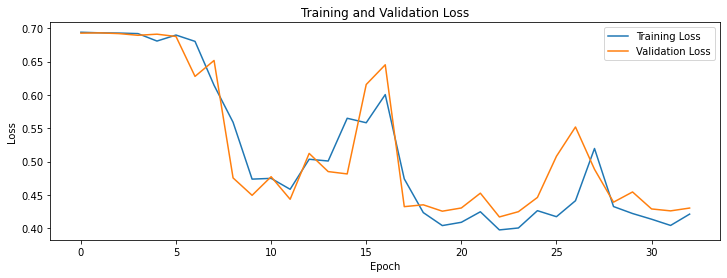

In [40]:
plt.figure(figsize=(12, 4))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 정확도(Accuracy) 그래프 시각화

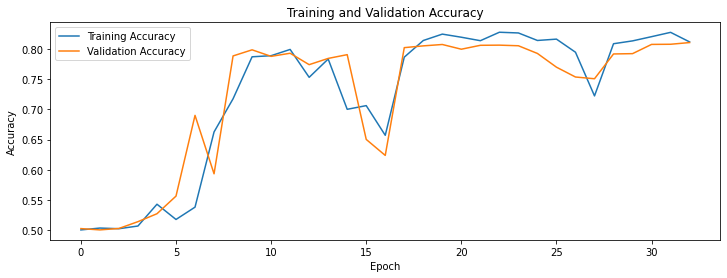

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 1D CNN Model

1. CNN 모델의 검증 정확도: 0.8381
2. CNN 모델의 검증 정확도: 0.8432
3. CNN 모델의 검증 정확도: 0.8421
4. CNN 모델의 검증 정확도: 0.8415
5. CNN 모델의 검증 정확도: 0.8402
6. CNN 모델의 검증 정확도: 0.8223
7. CNN 모델의 검증 정확도: 0.4998
8. CNN 모델의 검증 정확도: 0.4998

In [42]:
loss, accuracy = model_cnn.evaluate(X_val, y_val, verbose=1)
print(f"CNN 모델의 검증 정확도: {accuracy:.4f}")

914/914 [==============================] - 4s 4ms/step - loss: 0.6932 - accuracy: 0.4998
CNN 모델의 검증 정확도: 0.4998


#### 손실(Loss) 그래프 시각화

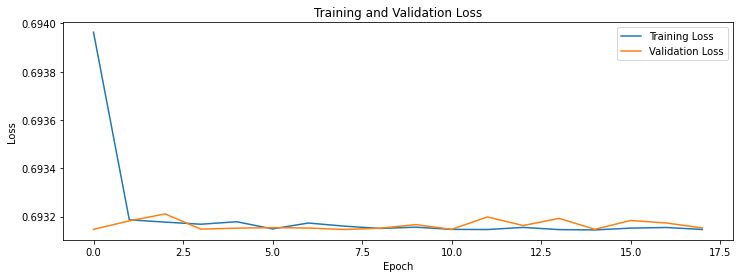

In [43]:
plt.figure(figsize=(12, 4))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 정확도(Accuracy) 그래프 시각화

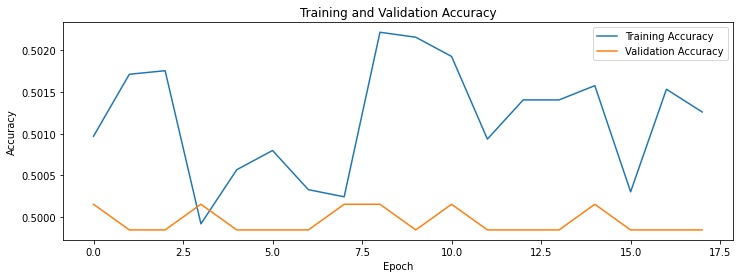

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### LSTM Model

1. LSTM 모델의 검증 정확도: 0.8506
2. LSTM 모델의 검증 정확도: 0.8463
3. LSTM 모델의 검증 정확도: 0.8328
4. LSTM 모델의 검증 정확도: 0.8340
5. LSTM 모델의 검증 정확도: 0.8321
6. LSTM 모델의 검증 정확도: 0.8406
7. LSTM 모델의 검증 정확도: 0.8311
8. LSTM 모델의 검증 정확도: 0.8425

In [45]:
loss, accuracy = model_lstm.evaluate(X_val, y_val, verbose=1)
print(f"LSTM 모델의 검증 정확도: {accuracy:.4f}")

914/914 [==============================] - 3s 4ms/step - loss: 0.5138 - accuracy: 0.8470
LSTM 모델의 검증 정확도: 0.8470


#### 손실(Loss) 그래프 시각화

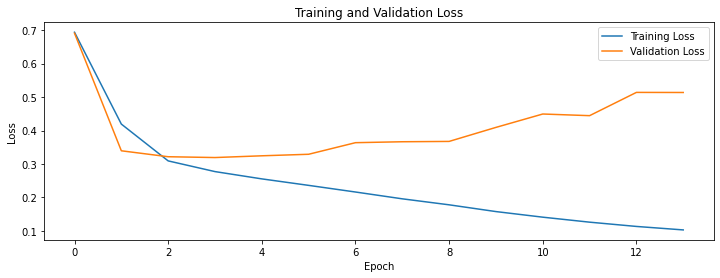

In [46]:
plt.figure(figsize=(12, 4))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#### 정확도(Accuracy) 그래프 시각화

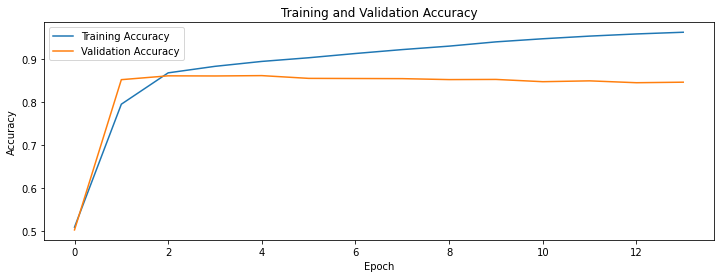

In [47]:
plt.figure(figsize=(12, 4))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Transformer 모델

In [48]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.model_selection import train_test_split

In [49]:
# 데이터셋 클래스 정의
class NaverMovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [62]:
# BERT 토크나이저로 문장을 토크나이징
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# 원본 데이터 로드
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

# 'document' 열에서 리뷰 텍스트 추출
X_train_texts = train_data['document'].astype(str).tolist()
X_test_texts = test_data['document'].astype(str).tolist()

# 토크나이징 및 데이터셋 준비
train_encodings = tokenizer(X_train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(X_test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

train_dataset = NaverMovieDataset(train_encodings, y_train)
test_dataset = NaverMovieDataset(test_encodings, y_test)

In [63]:
# DataLoader 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [64]:
# BERT 모델 로딩
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.to(device)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
# 훈련 루프
model.train()
for epoch in range(10):  # 에폭 진행
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

/tmp/ipykernel_54/2822846658.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
from sklearn.metrics import accuracy_score

# 평가 모드로 전환
model.eval()

# 정확도 계산을 위한 변수 초기화
total_eval_accuracy = 0

# 평가 루프 시작
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    
    # 기울기 계산 없이 예측
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    
    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    
    # 배치 내 정확도 계산
    batch_accuracy = accuracy_score(np.argmax(logits, axis=1).flatten(), label_ids.flatten())
    
    # 총 정확도 업데이트
    total_eval_accuracy += batch_accuracy

# 전체 정확도 계산
avg_test_accuracy = total_eval_accuracy / len(test_loader)
print(f"Test set accuracy: {avg_test_accuracy:.4f}")

## 학습된 Embedding 레이어 분석

### Simple RNN Model

In [51]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10002, 100)


In [52]:
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/Sentiment_Analysis/word2vec_rnn.txt'
with open(word2vec_file_path, 'w') as f:
    f.write(f'{vocab_size-4} {word_vector_dim}\n')  # 파일 첫 줄에 단어 개수와 벡터의 차원 수 기록

    vectors = model_rnn.get_weights()[0]
    for i in range(4, vocab_size):  # 특수 문자 제외
        if i in index_to_word:      # index_to_word에 i가 있을 때만 실행
            f.write(f'{index_to_word[i]} {" ".join(map(str, list(vectors[i, :])))}\n')

### 1D CNN Model

In [53]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10002, 100)


In [54]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/Sentiment_Analysis/word2vec_cnn.txt'
with open(word2vec_file_path, 'w') as f:
    f.write(f'{vocab_size-4} {word_vector_dim}\n')  # 파일 첫 줄에 단어 개수와 벡터의 차원 수 기록

    vectors = model_rnn.get_weights()[0]
    for i in range(4, vocab_size):  # 특수 문자 제외
        if i in index_to_word:      # index_to_word에 i가 있을 때만 실행
            f.write(f'{index_to_word[i]} {" ".join(map(str, list(vectors[i, :])))}\n')

### LSTM Model

In [55]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10002, 100)


In [56]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/Sentiment_Analysis/word2vec_lstm.txt'
with open(word2vec_file_path, 'w') as f:
    f.write(f'{vocab_size-4} {word_vector_dim}\n')  # 파일 첫 줄에 단어 개수와 벡터의 차원 수 기록

    vectors = model_rnn.get_weights()[0]
    for i in range(4, vocab_size):  # 특수 문자 제외
        if i in index_to_word:      # index_to_word에 i가 있을 때만 실행
            f.write(f'{index_to_word[i]} {" ".join(map(str, list(vectors[i, :])))}\n')

## 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용한다.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러온다. 
    - 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용한다. 
    - 좀더 자세한 활용법에 대해선 다음 링크들을 참조
        - [링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models)
        - [링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

```Python
# 예시코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]
```

In [57]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['영화']

In [58]:
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

## 회고

프로젝트를 통해 직면했던 어려움과 이를 극복한 경험은 크게 두 가지로 요약할 수 있다.   
첫 번째로, 데이터 전처리 과정의 복잡성이 있었다. 다양한 전처리 기법을 적용하며 가장 효과적인 조합을 찾기 위해 많은 시간과 노력이 필요했다.   
이 과정에서 실험을 반복하며 최적의 전처리 방법을 찾아내었고, 이는 모델의 성능 향상에 큰 기여를 했다.

두 번째로, 모델 성능의 한계에 부딪혔다. 초기 모델들의 성능이 기대에 못 미쳐, 이를 개선하기 위한 방법을 모색했다.   
사전 훈련된 Word2Vec 임베딩의 적용과 함께 모델의 하이퍼파라미터를 조정함으로써, 성능을 상당히 개선할 수 있었다.

이 과정에서 배운 점은 다양하다.   
먼저, 자연어 처리에서의 데이터 전처리 기법의 중요성을 깨달았다. 적절한 데이터 전처리는 모델의 성능을 극대화하는 데 필수적이다. 
또한, 다양한 딥러닝 모델의 아키텍처와 각각의 장단점에 대한 이해도 깊어졌다.  
마지막으로, 사전 훈련된 임베딩의 활용 방법과 그 효과에 대해서도 학습할 수 있었습니다. 이는 향후 다른 자연어 처리 프로젝트에 큰 도움이 될 것이다.

향후 계획으로는 모델의 성능을 더욱 향상시킬 수 있는 방법을 탐색하고, 더 많은 데이터와 복잡한 모델 구조를 실험해보고자 한다.  
특히, BERT와 같은 최신 NLP 모델을 학습하고 프로젝트에 적용해보는 것이 목표다.  
이 프로젝트를 통해 자연어 처리와 딥러닝에 대한 실전 경험을 쌓을 수 있었으며, 이론과 실습을 통해 얻은 지식을 실제 문제에 적용해볼 수 있었다.   
앞으로도 계속해서 지식을 확장하고 새로운 도전을 해나갈 계획이다.